<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/misc/Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import random
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import functional as F

In [2]:
# Hyperparameter Section
BS = 64

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                             train=True, 
                                             transform=transform,
                                             download=True)
valid_dataset = torchvision.datasets.CIFAR10(root='/.data',
                                             train=False,
                                             transform=transform,
                                             download=True,
                                             )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BS,
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BS,
                          shuffle=False)

In [10]:
# Form a lookup
sample_train_loader = DataLoader(train_dataset,
                                 batch_size=1,
                                 shuffle=False,)
sample_test_loader = DataLoader(valid_dataset,
                                batch_size=1,
                                shuffle=False)

x_train = [sample[0].squeeze(0).numpy() for sample in sample_train_loader]
y_train = [sample[1].item() for sample in sample_train_loader]

x_test = [sample[0].squeeze(0).numpy() for sample in sample_test_loader]
y_test = [sample[1].item() for sample in sample_test_loader]

class_idx_to_train = defaultdict(list)
for train_idx, y in enumerate(y_train):
  class_idx_to_train[y].append(train_idx)

class_idx_to_test = defaultdict(list)
for test_idx, y in enumerate(y_test):
  class_idx_to_test[y].append(test_idx)

In [11]:
# Check shape
print(x_train[0].shape, y_train[0])

(3, 32, 32) 6


In [90]:
class AnchorPositivePairs(Dataset):
  def __init__(self, class_idx_to_train, num_classes=10):
    self.class_idx_to_train = class_idx_to_train
    self.num_classes = num_classes

  def __len__(self,):
    return len(self.class_idx_to_train)
  
  def __getitem__(self, idx):
    anchors = []
    positives = []
    for batch_size in range(idx + 1):
      for class_idx in range(self.num_classes):
        examples_for_class = self.class_idx_to_train[class_idx]
        anchor_idx = random.choice(examples_for_class)
        positive_idx = random.choice(examples_for_class)
        while positive_idx == anchor_idx:
          positive_idx = random.choice(examples_for_class)
        anchors.append(x_train[anchor_idx])
        positives.append(x_train[positive_idx])
    return {
        'anchors': anchors,
        'positives': positives,
    }
  
  def collate_fn(self, batch):
    for sample in batch:
      anchors = sample['anchors']
      positives = sample['positives']
    anchors = torch.from_numpy(np.stack(anchors))
    positives = torch.from_numpy(np.stack(positives))
    return {
        'anchors': anchors,
        'positives': positives,
    }

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


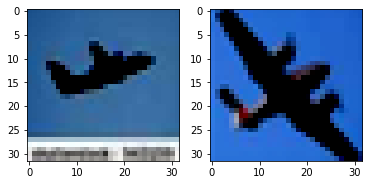

In [140]:
import matplotlib.pyplot as plt

sample_dataset = AnchorPositivePairs(class_idx_to_train)
loader = DataLoader(sample_dataset, batch_size=1, collate_fn=sample_dataset.collate_fn)
for sample in loader:
  index = 0
  img_a = sample['anchors'][index]
  img_p = sample['positives'][index]
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(img_a.permute(1, 2, 0));
  ax[1].imshow(img_p.permute(1, 2, 0));
  break